# CS-E4650 Methods of Data Mining
# Project work
## Bernard Spiegl - 1023112

## Imports

In [1]:
import re

import numpy as np
import pandas as pd

import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download("punkt")
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
nltk.download("wordnet")

from sklearn import preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.cluster import KMeans, AgglomerativeClustering, SpectralClustering
from sklearn.manifold import TSNE
from sklearn.decomposition import SparsePCA, PCA, TruncatedSVD
from sklearn.metrics.cluster import normalized_mutual_info_score

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

from wordcloud import WordCloud

import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/spieglb1/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/spieglb1/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/spieglb1/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Preprocessing

### Data Loading

In [2]:
df = pd.read_csv("abstractdata5.csv", sep="#", header=None)
df[2] = df[2].apply(lambda x: word_tokenize(re.sub(r"[^\w\s]", "", x.lower())))
df[3] = df[3].apply(lambda x: word_tokenize(re.sub(r"[^\w\s]", "", x.lower())))
df[4] = df[2] + df[3]
df.drop(columns = [2, 3], inplace=True)
df.rename({0: "id", 1: "topic", 4: "docs"}, axis=1, inplace=True)
df

,id,topic,docs
0,id1,1,"[anomaly, detection, in, wide, area, imagery, ..."
1,id2,1,"[person, reidentification, with, deep, kroneck..."
2,id3,1,"[crack, detection, in, images, of, masonry, us..."
3,id4,5,"[towards, an, energy, efficient, code, generat..."
4,id5,5,"[subpolyhedral, scheduling, using, unittwovari..."
...,...,...,...
1327,id1328,1,"[colorimetric, pointofcare, paperbased, sensor..."
1328,id1329,1,"[calcium, identification, and, scoring, based,..."
1329,id1330,1,"[considering, filter, importance, and, irrepla..."
1330,id1331,4,"[lowcomplexity, bitserial, sequential, polynom..."


### Removing Stopwords and Stemming/Lemmatization

In [3]:
def clean_lem(words):
    lem = WordNetLemmatizer()
    tokens = [lem.lemmatize(word) for word in words if word not in stopwords.words("english") and len(word) > 3]
    return " ".join(tokens)

def clean_stem(words):
    snowball_stemmer = SnowballStemmer(language="english")
    stems = [snowball_stemmer.stem(word) for word in words if word not in stopwords.words("english") and len(word) > 3]
    return " ".join(stems)

In [4]:
df["docs"] = df["docs"].apply(lambda x: clean_stem(x))
df

,id,topic,docs
0,id1,1,anomali detect wide area imageri geniş alan gö...
1,id2,1,person reidentif deep kroneckerproduct match g...
2,id3,1,crack detect imag masonri use cnns signific bo...
3,id4,5,toward energi effici code generat mobil phone ...
4,id5,5,subpolyhedr schedul use unittwovariableperineq...
...,...,...,...
1327,id1328,1,colorimetr pointofcar paperbas sensor urinari ...
1328,id1329,1,calcium identif score base echocardiographi ex...
1329,id1330,1,consid filter import irreplac filter prune dee...
1330,id1331,4,lowcomplex bitseri sequenti polynomi basi fini...


### Vectorizing

In [5]:
vectorizer = TfidfVectorizer()
vectorized = preprocessing.normalize(vectorizer.fit_transform(df["docs"]))
tf_idf = pd.DataFrame(data=vectorized.toarray(), columns=vectorizer.get_feature_names())

## Clustering

### K-Means

In [6]:
kmeans = KMeans(n_clusters=5)
kmeans_preds = kmeans.fit_predict(vectorized)

### Agglomerative Clustering

In [7]:
agg_clust = AgglomerativeClustering(n_clusters=5, linkage="complete")
agg_preds = agg_clust.fit_predict(vectorized.toarray())

### Spectral Clustering

In [8]:
spectral_clust = SpectralClustering(n_clusters=5, affinity="nearest_neighbors")
spectral_preds = spectral_clust.fit_predict(vectorized)

## Cluster Plotting

In [30]:
def dim_reducer(method, dim):
    if method == "tsne":
        return TSNE(n_components=dim)
    elif method == "pca":
        return PCA(n_components=dim)
    elif method == "tsvd":
        return TruncatedSVD(n_components=dim)
    
def plot_cluster_2d(vectorized, preds, method):
    data = dim_reducer(method, 2).fit_transform(vectorized.toarray())
    sns.scatterplot(data[:, 0], data[:, 1], c=preds)
    plt.savefig(f"{method}_2d.png")

def plot_cluster_3d(vectorized, preds, method):
    data = dim_reducer(method, 3).fit_transform(vectorized.toarray())
    fig = plt.figure()
    ax = fig.gca(projection="3d")
    ax.scatter(data[:, 0], data[:, 1], data[:, 2], c=preds)
    plt.savefig(f"{method}_3d.png")
    plt.show()
    

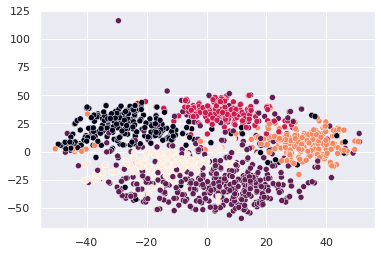

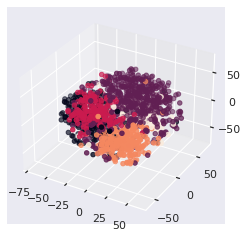

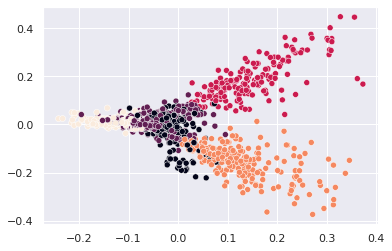

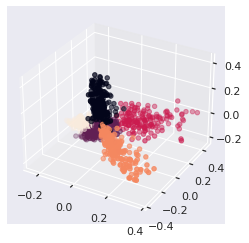

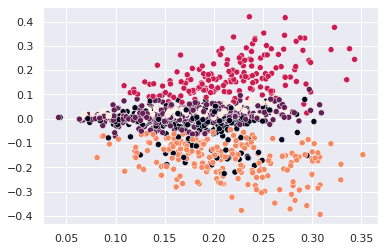

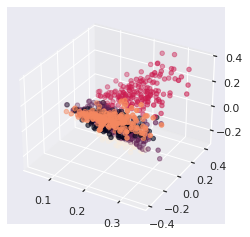

In [31]:
methods = ["tsne", "pca", "tsvd"]
for method in methods:
    plot_cluster_2d(vectorized, kmeans_preds, method)
    plot_cluster_3d(vectorized, kmeans_preds, method)

## Results

### Scoring

In [32]:
def NMI_score(predictions):
    return normalized_mutual_info_score(df["docs"], predictions, average_method="geometric")

In [33]:
print(f"K-Means: {NMI_score(kmeans_preds):.3f}\n" \
      f"Agglomerative: {NMI_score(agg_preds):.3f}\n"\
      f"Spectral: {NMI_score(spectral_preds):.3f}")

K-Means: 0.461
Agglomerative: 0.447
Spectral: 0.432


### Top Words per Cluster

In [34]:
def plot_top_words(tf_idf, preds, top_n):
    for label in np.sort(np.unique(preds)):
        scores = np.mean(tf_idf[np.where(preds==label)], axis=0)
        sorted_indices = np.argsort(scores)[::-1][:top_n]
        words = vectorizer.get_feature_names()
        top_words = [(words[i], scores[i]) for i in sorted_indices]
        df = pd.DataFrame(top_words, columns=["Words", "Score"])
        plt.title(f"Most common words in cluster {label}")
        sns.barplot(x="Score", y="Words", orient="h", data=df[:top_n])
        plt.savefig(f"top_n_{label}")
        plt.show()

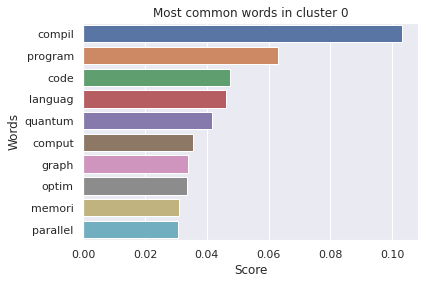

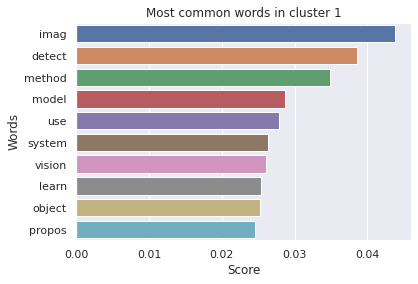

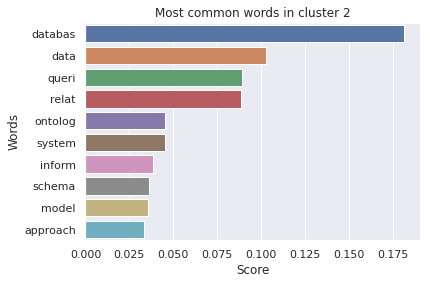

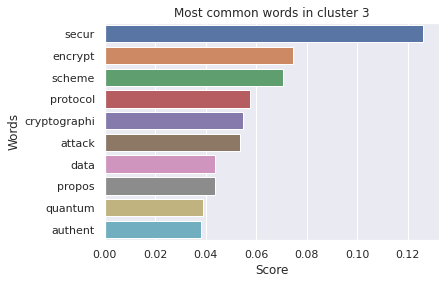

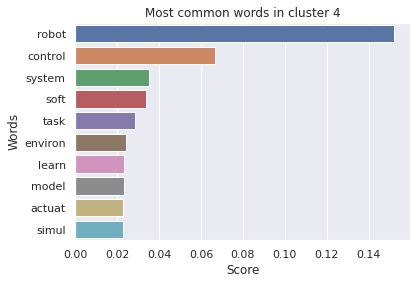

In [35]:
plot_top_words(tf_idf.to_numpy(), kmeans_preds, 10)

### Word Clouds

In [36]:
def plot_wordcloud(centroids):
    wordcloud = WordCloud(max_font_size=100, background_color="white")
    
    for cluster_no in range(len(centroids)):
        wordcloud_centroid_dict = dict()
        values = centroids.T[cluster_no].sort_values(ascending = False).reset_index().values
        for j in range(len(values)):
            wordcloud_centroid_dict[values[j, 0]] = values[j, 1]
            
        wordcloud.generate_from_frequencies(wordcloud_centroid_dict)
        
        plt.figure()
        plt.title(f"Cluster {cluster_no}")
        plt.imshow(wordcloud)
        plt.axis("off")
        plt.savefig(f"wordcloud_{cluster_no}")
        plt.show()

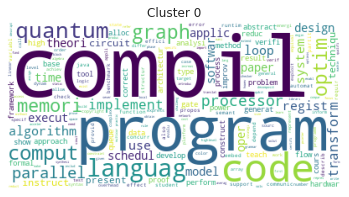

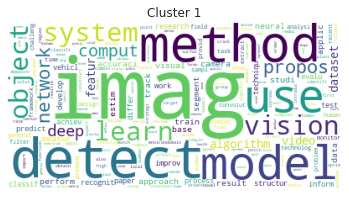

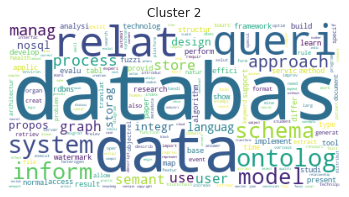

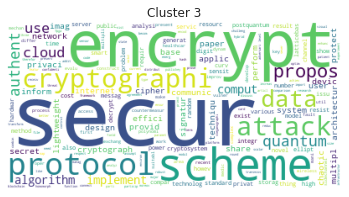

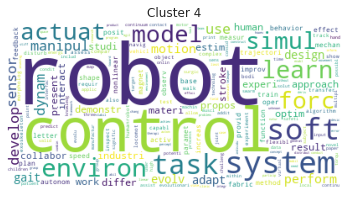

In [37]:
centroids = pd.DataFrame(kmeans.cluster_centers_)
centroids.columns = tf_idf.columns
plot_wordcloud(centroids)